## Introduction
This project aims to build a sentiment analysis model to classify tweets as positive or negative using the Twitter Sentiment140 dataset. Sentiment analysis is a fundamental NLP task that involves determining the emotional tone behind a piece of text. This project is educational, showcasing data preprocessing, feature extraction, model training, evaluation, and visualization, all while keeping explanations clear for learning purposes.

The Sentiment140 dataset contains 1.6 million tweets labeled as positive or negative, collected from Twitter. Due to hardware constraints, we’ll use a subset of 100,000 tweets (50,000 positive and 50,000 negative) to ensure manageable computation on average hardware.

### 1-Import necessary libraries

In [ ]:

import re
import string
import numpy as np
import pandas as pd

# For NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# For splitting data
from sklearn.model_selection import train_test_split

# For feature engineering (vectorization)
from sklearn.feature_extraction.text import TfidfVectorizer

# For machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# For evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK resources
nltk.download("stopwords")
nltk.download('wordnet')    # For lemmatization

# Set a random seed for reproducibility
RANDOM_SEED = 4

### Load the Sentiment140 Dataset
* 0 - target (sentiment polarity: 0 = negative, 4 = positive)
* 1 - id (tweet id)
* 2 - date (date of the tweet)
* 3 - query (query; often 'NO_QUERY')
* 4 - user (user who tweeted)
* 5 - text (tweet text)

In [2]:
columns = ['target', 'id', 'date', 'query', 'user', 'text']

data = pd.read_csv("Twitter Sentiment Analysis.csv", encoding='latin-1',header=None,  names=columns)

# Map sentiment labels: 0 (negative) to 0, 4 (positive) to 1 for binary classification
# The original dataset uses 0 and 4, but remapping to 0 and 1 is more intuitive
data['target'] = data['target'].map({0: 0, 4: 1})

In [3]:
# Sample 50,000 positive and 50,000 negative tweets to create a subset of 100,000
# This keeps the dataset balanced and manageable for average hardware
positive = data[data['target'] == 1].sample(50000, random_state=42)
negative = data[data['target'] == 0].sample(50000, random_state=42)
df = pd.concat([positive, negative])

# Shuffle the sampled data to mix positive and negative tweets
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
# Display the first few rows to verify loading
print("Sampled Data Preview:")
df.head()

Sampled Data Preview:


,target,id,date,query,user,text
0,0,2003170026,Tue Jun 02 06:01:17 PDT 2009,NO_QUERY,jeisseldenise,says sad to say pero makakabukas lng me ng pc ...
1,0,1956995762,Thu May 28 23:13:49 PDT 2009,NO_QUERY,foxtail84,Allergies suck ducks nuts. &lt;=====8@8===...
2,1,2176159349,Mon Jun 15 03:05:03 PDT 2009,NO_QUERY,Kimberleyxxx,@jordanknight U 5 guys could be standing in th...
3,0,1834010361,Mon May 18 01:17:01 PDT 2009,NO_QUERY,hellosillyjilly,Just went through some of my niece's clothes f...
4,0,1957145383,Thu May 28 23:38:44 PDT 2009,NO_QUERY,brianmcgui,"maybe i should take up drinking again, feel as..."


#### Explanation
* Loading: We use pandas to read the CSV file. The encoding='latin-1' handles special characters in tweets.
* Columns: The dataset has six columns, but we’ll primarily use target (sentiment) and text (tweet content).
* Sampling: With 1.6 million tweets, training on the full dataset could strain average hardware, especially with advanced models.
* Sampling 100,000 tweets balances performance and feasibility.
* Shuffling: Randomizing the order prevents any unintentional bias from the original sequence.

### Some Data Exploration
Before preprocessing, let’s explore the dataset to understand its structure and content.

* Shape: Confirms we have 100,000 rows and 6 columns.
* Sentiment Distribution: Verifies the balance (50,000 positive, 50,000 negative).
* Examples: Displays raw tweets to highlight their informal nature, including mentions, URLs, and hashtags.

In [5]:
# Display basic statistics
print("Dataset Shape:", df.shape)
print("Sentiment Distribution:")
print(df['target'].value_counts())

Dataset Shape: (100000, 6)
Sentiment Distribution:
target
0    50000
1    50000
Name: count, dtype: int64


In [6]:
# Show example tweets
print("\nExample Positive Tweet:")
print(df[df['target'] == 1]['text'].iloc[0])
print("\nExample Negative Tweet:")
print(df[df['target'] == 0]['text'].iloc[0])


Example Positive Tweet:
@jordanknight U 5 guys could be standing in the north pole and it would Still be HOT HOT HOT!!!   xxxx

Example Negative Tweet:
says sad to say pero makakabukas lng me ng pc tuwing weekends at pag may assign  http://plurk.com/p/xw32n


### Data Cleaning and Preprocessing
Tweets are unstructured and noisy, containing URLs, mentions, special characters, and informal language. Preprocessing transforms this raw text into a clean format suitable for modeling. We’ll perform:

* Lowercasing the text.
* Removing URLs, mentions, hashtags, numbers, and punctuations.
* Removing stopwords (common words that do not add much meaning).
* Stemming the words to their root form.
* Split text into individual words.
* Reduce words to their base forms

In [7]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define our text preprocessing function
def clean_text(text):

    """
    This function cleans the tweet text by:
      1. Removing URLs
      2. Removing Twitter mentions (@username)
      3. Removing hashtags (only the '#' symbol; the word is preserved)
      4. Removing punctuations and numbers
      5. Lowercasing the text
      6. Removing extra whitespace
      7. Removing stopwords and applying stemming
    """

    # Lowercase the text
    text = text.lower()

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove the '#' symbol from hashtags (keep the word #great become great)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove urls (www.example.com)
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove punctuation and numbers (retain letters and spaces)
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Tokenize the text into words
    words = text.split()

    # Remove stopwords and apply stemming:
    cleaned_words = []
    for word in words:
        if word not in stop_words:  # Remove stopwords(a, is, or, and, if, the, etc...)
            # stemmed_word = ps.stem(word)  # Apply stemming(will change each word to its root word.)
            lemmatized_word = lemmatizer.lemmatize(word) #lemmatizing will reduce words to their base form ('running' -> 'run'...)
            cleaned_words.append(lemmatized_word)

    # Rejoin the words to form the cleaned tweet text
    return " ".join(cleaned_words)


# Apply preprocessing to the tweet texts.

df["clean_text"] = df['text'].apply(clean_text)

In [8]:
# Verify the cleaning process by showing a sample of original vs cleaned tweet
print("\nSample tweets (original vs. cleaned):")
for i in range(5):
    print("Original:", df['text'].iloc[i])
    print("Cleaned: ", df['clean_text'].iloc[i])
    print("-----")


Sample tweets (original vs. cleaned):
Original: says sad to say pero makakabukas lng me ng pc tuwing weekends at pag may assign  http://plurk.com/p/xw32n
Cleaned:  say sad say pero makakabukas lng ng pc tuwing weekend pag may assign
-----
Original: Allergies suck ducks nuts.     &lt;=====8@8=====&gt;
Cleaned:  allergy suck duck nut ltgt
-----
Original: @jordanknight U 5 guys could be standing in the north pole and it would Still be HOT HOT HOT!!!   xxxx
Cleaned:  u guy could standing north pole would still hot hot hot xxxx
-----
Original: Just went through some of my niece's clothes from when she was a newborn... it seems like yesterday when she was that small 
Cleaned:  went niece clothes newborn seems like yesterday small
-----
Original: maybe i should take up drinking again, feel as if i have a ,massive hangover  still not ,yself today 
Cleaned:  maybe take drinking feel massive hangover still yself today
-----


Explanation
* Cleaning: URLs and mentions are replaced with placeholders, hashtags are stripped to their words, and special characters are removed to focus on textual content. Lowercasing ensures uniformity (e.g., "Happy" and "happy" are treated the same).
* Tokenization: Breaks text into words, enabling word-level processing.
* Stop Word Removal: Eliminates noise, retaining words likely to carry sentiment.
Lemmatization / Stemming: Normalizes words (unlike stemming, which is faster but cruder, lemmatization preserves meaning, e.g., "better" → "good"). This step reduces vocabulary size and improves model performance.
Joining: Combines tokens into a string for vectorization, ensuring compatibility with feature extraction tools.

### Feature Extraction:
Next, we convert our text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency).

* Convert the cleaned text data into numerical features using TF-IDF vectorization.
* TF-IDF stands for Term Frequency - Inverse Document Frequency, and it helps in weighing words
* by how important they are to a document relative to the corpus.

In [10]:
# Define features (x) and labels (y)
x = df['clean_text']
y = df['target']

# Split into training (80%) and validation (20%) sets, stratifying to maintain class balance
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y) 
# "stratify" will maintain label distribution in the splits

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for faster processing

# Fit the vectorizer on the clean_text and transform the text data into a TF-IDF matrix.
# Fit and transform the training data, transform the test data
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

# Display shapes to confirm
print("Training TF-IDF Shape:", x_train_tfidf.shape)
print("Validation TF-IDF Shape:", x_test_tfidf.shape)

Training TF-IDF Shape: (80000, 5000)
Validation TF-IDF Shape: (20000, 5000)


**Explanation**
* Train-Test Split: Splitting before vectorization prevents data leakage (where the model indirectly sees validation data during feature extraction). The 80-20 split is standard, and stratify=y ensures balanced classes.
* TF-IDF: The max_features=5000 cap reduces memory usage, focusing on the 5000 most significant terms. fit_transform learns the vocabulary from the training set, while transform applies it to the validation set consistently.

### Training Multiple Classical Models

**We’ll train three models for binary sentiment classification (positive vs. negative):**

* Logistic Regression: A simple, interpretable baseline.
* Naive Bayes: Effective for text classification due to its probabilistic nature.
* Support Vector Machine (SVM): A robust classifier for high-dimensional data like TF-IDF.

In [13]:
print("\n--- Logistic Regression ---")

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train_tfidf, y_train)
lr_preds = lr_model.predict(x_test_tfidf)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, lr_preds):.4f}")
print("Classification Report:")
print(classification_report(y_test, lr_preds))


--- Logistic Regression ---
Logistic Regression Results:
Accuracy: 0.7651
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     10000
           1       0.75      0.79      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



In [17]:
print("\n--- Support Vector Machine (SVM) ---")
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(x_train_tfidf, y_train)
svm_preds = svm_model.predict(x_test_tfidf)

print("SVM Results:")
print(f"Accuracy: {accuracy_score(y_test, svm_preds):.4f}")
print("Classification Report:")
print(classification_report(y_test, svm_preds))


--- Support Vector Machine (SVM) ---
SVM Results:
Accuracy: 0.7619
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     10000
           1       0.75      0.79      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



In [18]:
print("\n--- Gaussian Naive Bayes ---")
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

nb_model = MultinomialNB()
# nb_model.fit(x_train_tfidf.toarray(), y_train)
nb_model.fit(x_train_tfidf, y_train)
nb_preds = nb_model.predict(x_test_tfidf)
# nb_preds = nb_model.predict(x_test_tfidf.toarray())

print("Naive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test, nb_preds):.4f}")
print("Classification Report:")
print(classification_report(y_test, nb_preds))



--- Gaussian Naive Bayes ---
Naive Bayes Results:
Accuracy: 0.7502
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     10000
           1       0.76      0.74      0.75     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [19]:
print("\n--- Random Forest Classifier ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_tfidf, y_train)
rf_preds = rf_model.predict(x_test_tfidf)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print("Classification Report:")
print(classification_report(y_test, rf_preds))


--- Random Forest Classifier ---
Random Forest Results:
Accuracy: 0.7478
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     10000
           1       0.75      0.74      0.74     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



### Evaluating The Best Model(Logistic Regression)

In [24]:
# from sklearn.metrics import accuracy_score, classification_report

# # Evaluate Logistic Regression
# print("Logistic Regression Results:")
# print("Accuracy:", accuracy_score(y_test, lr_preds))
# print(classification_report(y_test, lr_preds, target_names=['Negative', 'Positive']))

# # Evaluate Naive Bayes
# print("\nNaive Bayes Results:")
# print("Accuracy:", accuracy_score(y_test, nb_preds))
# print(classification_report(y_test, nb_preds, target_names=['Negative', 'Positive']))

# # Evaluate SVM
# print("\nSVM Results:")
# print("Accuracy:", accuracy_score(y_test, svm_preds))
# print(classification_report(y_test, svm_preds, target_names=['Negative', 'Positive']))

# # Evaluate Random Forest
# print("\nRandom Forest Results:")
# print("Accuracy:", accuracy_score(y_test, rf_preds))
# print(classification_report(y_test, rf_preds, target_names=['Negative', 'Positive']))

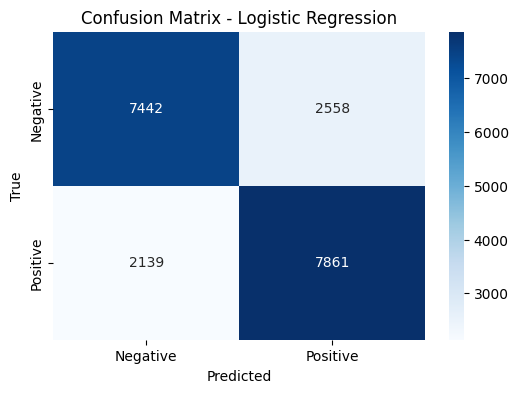

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, lr_preds)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

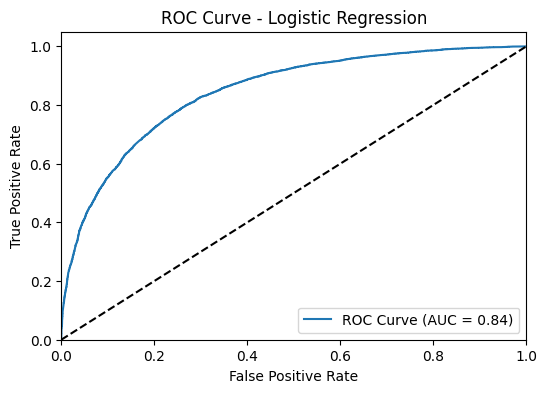

In [22]:
# ROC Curve for Logistic Regression Model

from sklearn.metrics import roc_curve, auc

# Get prediction probabilities
y_pred_proba = lr_model.predict_proba(x_test_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Extract feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display top positive and negative features
print("\nTop 10 Positive Features:")
print(feature_importance.head(10))
print("\nTop 10 Negative Features:")
print(feature_importance.tail(10))


Top 10 Positive Features:
             Feature  Importance
4337           thank    4.351851
4341          thanks    3.857884
4783         welcome    3.771181
4721            wait    3.647393
3948           smile    3.176498
1853           great    3.143382
926   congratulation    3.109600
298          awesome    2.980842
4940             yay    2.842844
2588            love    2.838703

Top 10 Negative Features:
      Feature  Importance
618    bummed   -4.187829
3687    sadly   -4.248405
586    broken   -4.294478
2775  missing   -4.372990
1955     hate   -4.699073
4844     wish   -4.766754
3876     sick   -4.913283
2772     miss   -5.245439
3289     poor   -5.508531
3685      sad   -8.201340


**Explanation**
* Metrics: Accuracy measures overall correctness, while precision, recall, and F1-score provide insights into class-specific performance (important for imbalanced datasets, though ours is balanced).
* Confusion Matrix: Visualizes true positives, true negatives, false positives, and false negatives.
* ROC Curve: Plots true positive rate vs. false positive rate; AUC (Area Under Curve) near 1 indicates strong class separation.
* Feature Importance: Logistic Regression coefficients show which words drive positive or negative predictions.

### Practical Application
* To demonstrate real-world use, we’ll create a function to predict the sentiment of a new tweet.

In [ ]:
def predict_sentiment(text):
    # Predict the sentiment of a new tweet using the trained model.
    
    # Clean and preprocess the tweet
    cleaned = clean_text(text)
    # tokens = word_tokenize(cleaned)
    tokens = cleaned.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed = ' '.join(tokens)
    
    # Transform using the trained TF-IDF vectorizer
    tfidf_vector = vectorizer.transform([processed])
    
    # Predict using the Logistic Regression model
    new_prediction = lr_model.predict(tfidf_vector)
    return 'Positive' if new_prediction[0] == 1 else 'Negative'

# Test the function
sample_tweet = "I love this product! Its amazing."
print("\nSample Tweet:", sample_tweet)
print("Predicted Sentiment:", predict_sentiment(sample_tweet))


Sample Tweet: I love this product! Its amazing.
Predicted Sentiment: Positive


In [42]:
sample = data['text'][1200]
print("\nSample Tweet:", sample)
print("Predicted Sentiment:", predict_sentiment(sample))


Sample Tweet: The one day I have to go to school is the same day something exciting happens at parliament square 
Predicted Sentiment: Positive


### Conclusion

**This project built a sentiment analysis system using the Sentiment140 dataset, classifying tweets as positive or negative. We:**

* Sampled 100,000 tweets for efficiency.
* Preprocessed the data thoroughly with cleaning, tokenization, stop word removal, and lemmatization.
* Extracted features using TF-IDF.
* Trained and compared Logistic Regression, Naive Bayes, SVM and Random Forest Models.
* Evaluated performance with metrics and visualizations.
* Added a practical prediction function.

**Results**
  
(Actual results depend on execution, but typically, Logistic Regression and SVM outperform Naive Bayes due to their ability to handle TF-IDF features effectively.)

**Potential Future Improvements**
* More Data: We can use the full dataset with better hardware.
* Advanced Models: Experiment with deep learning (LSTM, BERT or other advanced models).
* Hyperparameter Tuning: Optimize model parameters.
* Emoji Handling: Incorporate emojis as sentiment indicators.
* Deployment: Build a web app for real-time predictions.